In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = 'xoos0420' # USERNAME
os.environ['KAGGLE_KEY'] = '3fcce1f3acb429935a009c08fb889557' # KEY

In [3]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog.zip

100% 218M/218M [00:10<00:00, 23.9MB/s]
100% 218M/218M [00:10<00:00, 21.2MB/s]


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [6]:
def target_transforms(target):
  return torch.FloatTensor([target])


In [7]:
image_datasets = {
    'train': datasets.ImageFolder('/content/training_set/training_set', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('/content/test_set', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size= 32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['train'],
        batch_size= 32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

8005 2023


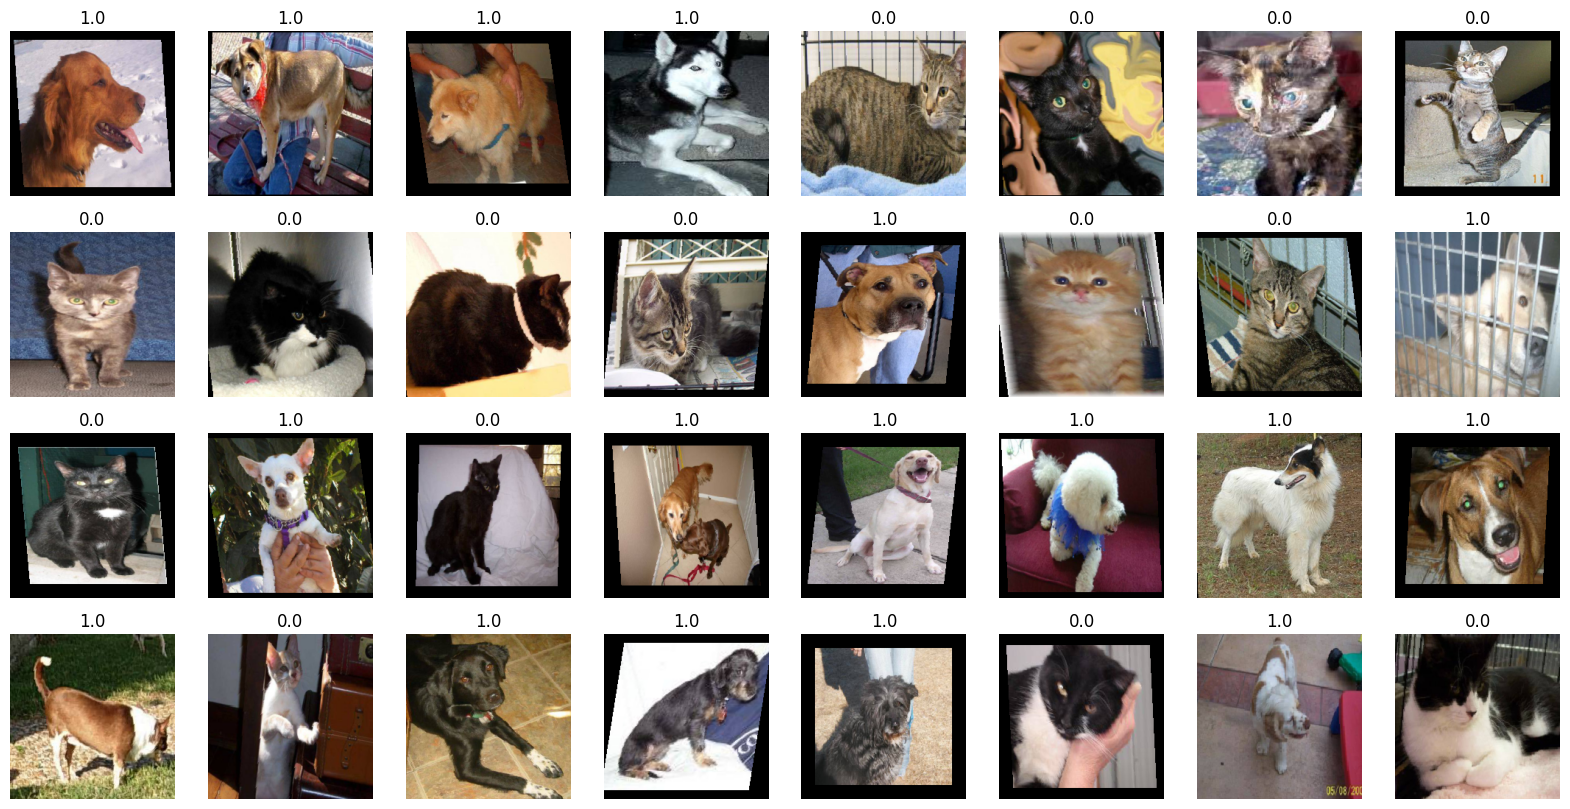

In [8]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(label.item())
    ax.axis('off')

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
model = models.resnet50(weights='IMAGENET1K_V1').to(device) #이미지넷을미리 학습후에 가져온다
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터(W, b)를 업데이터하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# 학습: fc 부분만 학습하므로 속도가 빠름

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 5
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/5, Loss: 0.1382, Accuracy: 94.30%
validation: Epoch    1/5, Loss: 0.0593, Accuracy: 97.68%
train     : Epoch    2/5, Loss: 0.0849, Accuracy: 96.48%
validation: Epoch    2/5, Loss: 0.0408, Accuracy: 98.58%
train     : Epoch    3/5, Loss: 0.0937, Accuracy: 96.25%
validation: Epoch    3/5, Loss: 0.0496, Accuracy: 98.31%
train     : Epoch    4/5, Loss: 0.0884, Accuracy: 96.56%
validation: Epoch    4/5, Loss: 0.0397, Accuracy: 98.49%
train     : Epoch    5/5, Loss: 0.0705, Accuracy: 97.26%
validation: Epoch    5/5, Loss: 0.0482, Accuracy: 98.13%


In [13]:
torch.save(model.state_dict(),'model.cat_dog')

In [14]:

model = models.resnet50().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [15]:
# 모델 로드
model.load_state_dict(torch.load('model.cat_dog'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

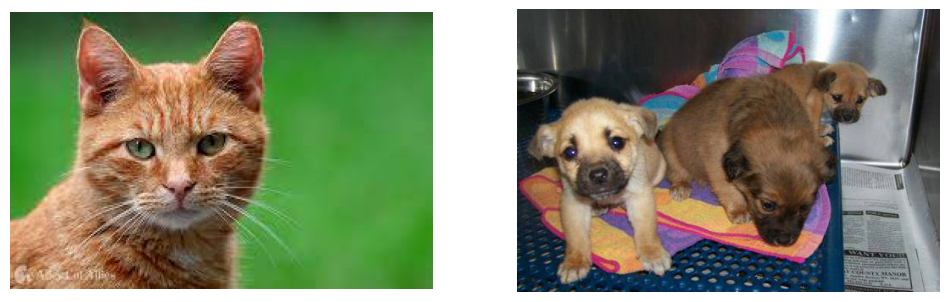

In [21]:
# 테스트
from PIL import Image

img1 = Image.open('/content/test_set/test_set/cats/tcat.jpg')
img2 = Image.open('/content/test_set/test_set/dogs/dog.4057.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [22]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [23]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [24]:
y_pred = model(test_batch)
y_pred

tensor([[2.9998e-04],
        [9.9832e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)

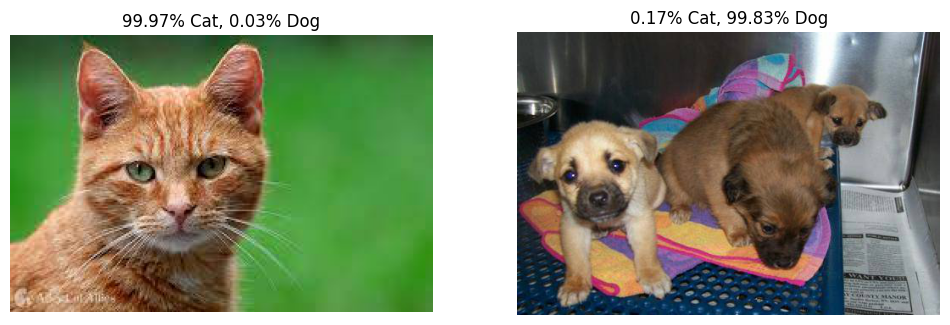

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0]) * 100:.2f}% Cat, {y_pred[0, 0] * 100:.2f}% Dog')
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title(f'{(1-y_pred[1, 0]) * 100:.2f}% Cat, {y_pred[1, 0] * 100:.2f}% Dog')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()